In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# Import data

In [2]:
crime = pd.read_csv('crime.csv')
crime_marijuana = pd.read_csv('crime_marijuana.csv')
police_districts = pd.read_csv('police_districts.csv')
state_senate_districts = pd.read_csv('state_senate_districts.csv')
business_improvement_districts = pd.read_csv('business_improvement_districts.csv')

In [3]:
crime.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [4]:
pd.DataFrame(crime.info()).to_excel('crime_info.xlsx')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463462 entries, 0 to 463461
Data columns (total 19 columns):
INCIDENT_ID               463462 non-null int64
OFFENSE_ID                463462 non-null int64
OFFENSE_CODE              463462 non-null int64
OFFENSE_CODE_EXTENSION    463462 non-null int64
OFFENSE_TYPE_ID           463462 non-null object
OFFENSE_CATEGORY_ID       463462 non-null object
FIRST_OCCURRENCE_DATE     463462 non-null object
LAST_OCCURRENCE_DATE      146006 non-null object
REPORTED_DATE             463462 non-null object
INCIDENT_ADDRESS          419513 non-null object
GEO_X                     459464 non-null float64
GEO_Y                     459464 non-null float64
GEO_LON                   459464 non-null float64
GEO_LAT                   459464 non-null float64
DISTRICT_ID               463462 non-null int64
PRECINCT_ID               463462 non-null int64
NEIGHBORHOOD_ID           463462 non-null object
IS_CRIME                  463462 non-null int64
IS_TRAFFIC

# Data preprocessing

## Missing value count

In [5]:
crime.isnull().sum()[crime.isnull().sum()>0]/crime.shape[0]*100

LAST_OCCURRENCE_DATE    68.496662
INCIDENT_ADDRESS         9.482762
GEO_X                    0.862638
GEO_Y                    0.862638
GEO_LON                  0.862638
GEO_LAT                  0.862638
dtype: float64

In [6]:
crime.isnull().sum()[crime.isnull().sum()>0].index

Index(['LAST_OCCURRENCE_DATE', 'INCIDENT_ADDRESS', 'GEO_X', 'GEO_Y', 'GEO_LON',
       'GEO_LAT'],
      dtype='object')

In [7]:
crime.drop(crime.isnull().sum()[crime.isnull().sum()>0].index, axis=1, inplace=True)
crime.isnull().sum()[crime.isnull().sum()>0]

Series([], dtype: int64)

## FIRST_OCCURRENCE_DATE processing

In [8]:
crime.FIRST_OCCURRENCE_DATE.head()

0     6/15/2016 11:31:00 PM
1    10/11/2017 12:30:00 PM
2       3/4/2016 8:00:00 PM
3      1/30/2018 7:20:00 PM
4      6/22/2017 8:53:00 PM
Name: FIRST_OCCURRENCE_DATE, dtype: object

In [9]:
# convert object to datetime format, use 24-hour clock and create date feature.
def judgeTime(x):
    x_lst = x.split()
    time = datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S')
    if x_lst[-1] == 'PM':
        return time+timedelta(hours=12)
    else:
        return time
crime['date'] = crime.FIRST_OCCURRENCE_DATE.apply(lambda x: judgeTime(x))
crime.date.head()

0   2016-06-15 23:31:00
1   2017-10-12 00:30:00
2   2016-03-04 20:00:00
3   2018-01-30 19:20:00
4   2017-06-22 20:53:00
Name: date, dtype: datetime64[ns]

In [10]:
# judge time of day and create timeOfDay feature.
def judgeTimeOfDay(x):
    if 5 <= x.hour < 12:
        return 'morning'
    elif 12 <= x.hour < 1:
        return 'noon'
    elif 1 <= x.hour < 5:
        return 'afternoon'
    elif 5 <= x.hour < 9:
        return 'evening'
    else:
        return 'night'
crime['timeOfDay'] = crime.date.apply(lambda x: judgeTimeOfDay(x))

In [11]:
crime.timeOfDay.value_counts()

night        313865
morning      107383
afternoon     42214
Name: timeOfDay, dtype: int64

In [12]:
# create dayOfWeek feature where Monday is 0 and Sunday is 6.
crime['dayOfWeek'] = crime.date.apply(lambda x: x.weekday())

In [13]:
crime.dayOfWeek.value_counts()

4    72851
3    69313
2    68327
1    66623
0    64436
5    63822
6    58090
Name: dayOfWeek, dtype: int64

## Auxiliary feature

### Integrating party data

In [14]:
crime.columns

Index(['INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION',
       'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE',
       'REPORTED_DATE', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID',
       'IS_CRIME', 'IS_TRAFFIC', 'date', 'timeOfDay', 'dayOfWeek'],
      dtype='object')

In [15]:
state_senate_districts.columns

Index(['DISTRICT', 'REP', 'PARTY', 'GLOBALID'], dtype='object')

In [16]:
data = pd.merge(crime, state_senate_districts[['DISTRICT', 'PARTY']], how='left', left_on='DISTRICT_ID', right_on='DISTRICT')

In [17]:
data.PARTY.value_counts()

R    313163
D    150299
Name: PARTY, dtype: int64

### Integrating business improvement district data

In [18]:
business_improvement_districts.columns

Index(['DISTRICT_ID', 'ACTIVE_OR_HISTORIC', 'DISTRICT_NAME',
       'CREATION_ORDINANCE', 'BNDRY_LAST_MODIFIED_DATE', 'LEGAL_START_DATE',
       'LEGAL_END_DATE', 'TAX_NUMBER', 'DATA_SOURCE', 'FILE_LINK', 'WEB_LINK',
       'COMMENTS_DISTRICT_SPECIFIC', 'COMMENTS_LEGISLATIVE_PROCESS',
       'WEB_LINK_STATE_DOLA', 'NOTES', 'SPECIAL_FEE_TYPE'],
      dtype='object')

In [19]:
data = pd.merge(data, business_improvement_districts[['DISTRICT_ID', 'DISTRICT_NAME']], how='left', on='DISTRICT_ID')

In [20]:
data.columns

Index(['INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION',
       'OFFENSE_TYPE_ID', 'OFFENSE_CATEGORY_ID', 'FIRST_OCCURRENCE_DATE',
       'REPORTED_DATE', 'DISTRICT_ID', 'PRECINCT_ID', 'NEIGHBORHOOD_ID',
       'IS_CRIME', 'IS_TRAFFIC', 'date', 'timeOfDay', 'dayOfWeek', 'DISTRICT',
       'PARTY', 'DISTRICT_NAME'],
      dtype='object')

## Feature select and process

In [21]:
cols_select = [
    'DISTRICT_ID', 'date', 'timeOfDay', 'dayOfWeek', 'PARTY', 'DISTRICT_NAME', 'IS_CRIME'
]

In [22]:
train = data[cols_select]

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463462 entries, 0 to 463461
Data columns (total 7 columns):
DISTRICT_ID      463462 non-null int64
date             463462 non-null datetime64[ns]
timeOfDay        463462 non-null object
dayOfWeek        463462 non-null int64
PARTY            463462 non-null object
DISTRICT_NAME    457722 non-null object
IS_CRIME         463462 non-null int64
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 28.3+ MB


In [24]:
dummies = pd.get_dummies(train.select_dtypes(np.object))
train.drop(train.select_dtypes(np.object).columns, inplace=True, axis=1)
train = pd.concat([train, dummies], axis=1, copy=False)
train.columns

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['DISTRICT_ID', 'date', 'dayOfWeek', 'IS_CRIME', 'timeOfDay_afternoon',
       'timeOfDay_morning', 'timeOfDay_night', 'PARTY_D', 'PARTY_R',
       'DISTRICT_NAME_CHERRY CREEK NORTH BUSINESS IMPROVEMENT DISTRICT NO. 1',
       'DISTRICT_NAME_CHERRY CREEK SUBAREA BUSINESS IMPROVEMENT DISTRICT',
       'DISTRICT_NAME_COLFAX BUSINESS IMPROVEMENT DISTRICT',
       'DISTRICT_NAME_DOWNTOWN DENVER BUSINESS IMPROVEMENT DISTRICT',
       'DISTRICT_NAME_OLD SOUTH GAYLORD BUSINESS IMPROVEMENT DISTRICT',
       'DISTRICT_NAME_WEST COLFAX BUSINESS IMPROVEMENT DISTRICT'],
      dtype='object')

In [25]:
train = train.rename(
    columns={
        'DISTRICT_NAME_CHERRY CREEK NORTH BUSINESS IMPROVEMENT DISTRICT NO. 1':
        'CCN_BID',
        'DISTRICT_NAME_CHERRY CREEK SUBAREA BUSINESS IMPROVEMENT DISTRICT':
        'CCS_BID',
        'DISTRICT_NAME_COLFAX BUSINESS IMPROVEMENT DISTRICT': 'C_BID',
        'DISTRICT_NAME_DOWNTOWN DENVER BUSINESS IMPROVEMENT DISTRICT':
        'DD_BID',
        'DISTRICT_NAME_OLD SOUTH GAYLORD BUSINESS IMPROVEMENT DISTRICT':
        'OSG_BID',
        'DISTRICT_NAME_WEST COLFAX BUSINESS IMPROVEMENT DISTRICT': 'WC_BID'
    })
train.columns

Index(['DISTRICT_ID', 'date', 'dayOfWeek', 'IS_CRIME', 'timeOfDay_afternoon',
       'timeOfDay_morning', 'timeOfDay_night', 'PARTY_D', 'PARTY_R', 'CCN_BID',
       'CCS_BID', 'C_BID', 'DD_BID', 'OSG_BID', 'WC_BID'],
      dtype='object')

## Exploratory data analysis

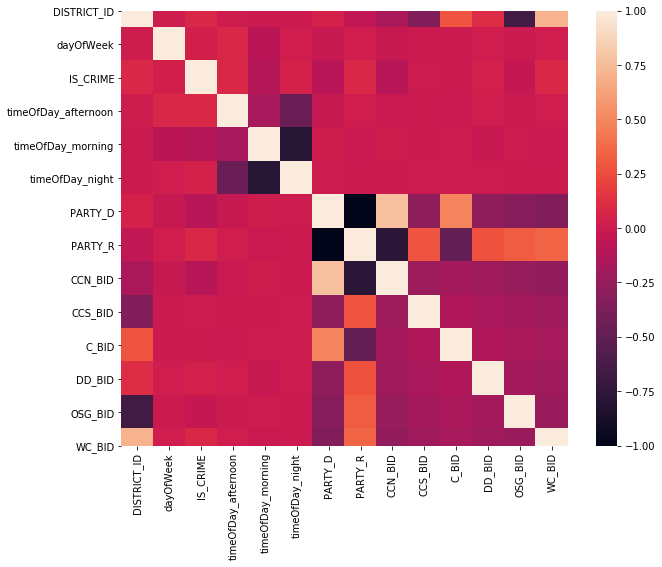

In [26]:
corr = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr)

In [27]:
len(cols_select)

7

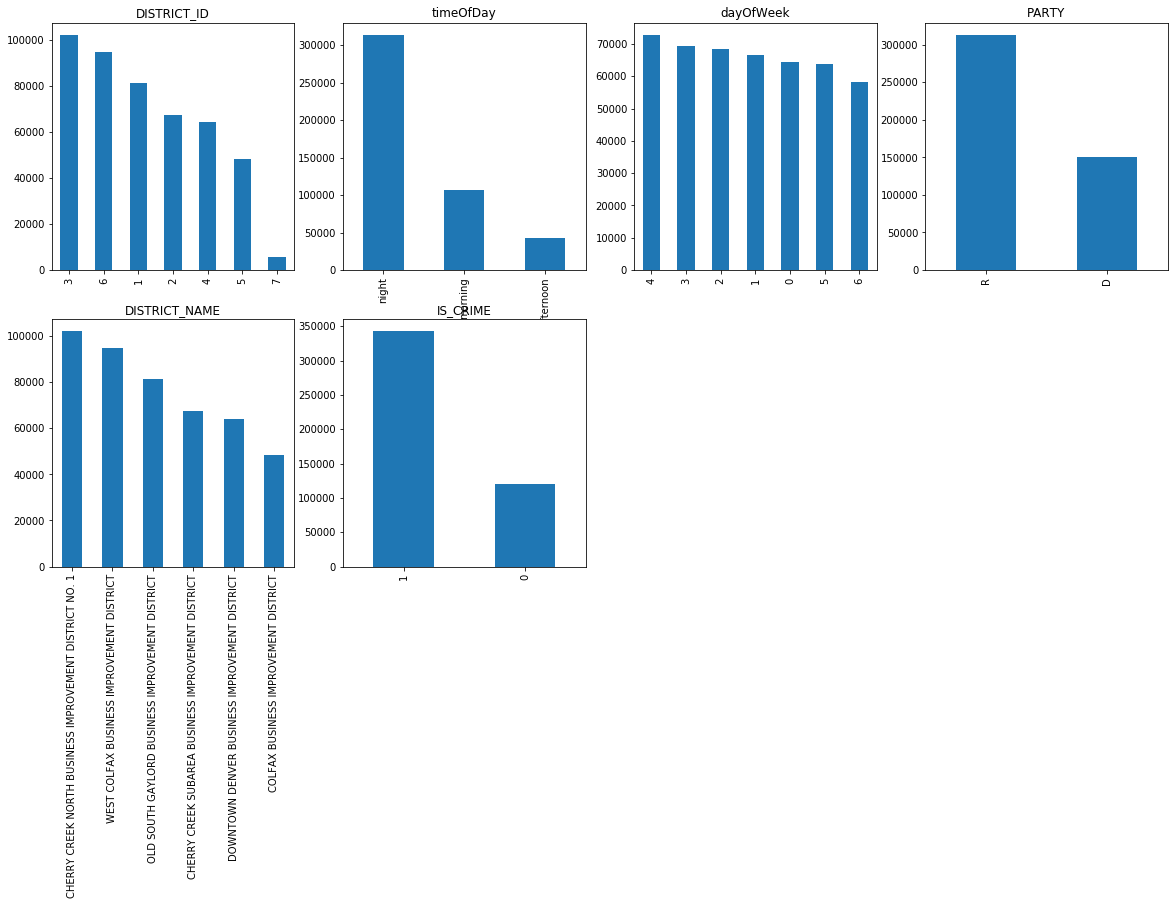

In [28]:
cols = cols_select[:]
cols.remove('date')
plt.figure(figsize=(20,10))
for i in range(len(cols)):
    plt.subplot(2,4,i+1)
    data[cols[i]].value_counts().plot.bar()
    plt.title(cols[i])

# save to csv

In [33]:
train.to_csv('train.csv', index=False)